<a href="https://colab.research.google.com/github/sofiadutta/PyTorch-Experiments/blob/master/Denoising-Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision 
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from tqdm.autonotebook import tqdm

import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from sklearn.metrics import accuracy_score

In [0]:
from google.colab import drive
drive.mount('/content/gdrive/')

import sys
sys.path.append('/content/gdrive/My Drive/MPDL/')

from mpdl import train_network, Flatten, View, weight_reset

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [0]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [0]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class View(nn.Module):
    def __init__(self, *shape):
        super(View, self).__init__()
        self.shape = shape
    def forward(self, input):
        return input.view(*self.shape) 

def moveTo(obj, device):
    if isinstance(obj, tuple):
        return tuple([moveTo(x, device) for x in obj])
    elif isinstance(obj, list):
        return [moveTo(x, device) for x in obj]
    elif isinstance(obj, torch.Tensor):
        return obj.to(device)
    else:
        return x        

def train_network(model, loss_func, train_loader, val_loader=None, score_funcs=None, 
                         epochs=50, device="cpu", checkpoint_file=None, 
                         lr_schedule=None, optimizer=None, disable_tqdm=False
                        ):
    """Train simple neural networks
    
    Keyword arguments:
    model -- the PyTorch model / "Module" to train
    loss_func -- the loss function that takes in batch in two arguments, the model outputs and the labels, and returns a score
    train_loader -- PyTorch DataLoader object that returns tuples of (input, label) pairs. 
    val_loader -- Optional PyTorch DataLoader to evaluate on after every epoch
    score_funcs -- A dictionary of scoring functions to use to evalue the performance of the model
    epochs -- the number of training epochs to perform
    device -- the compute lodation to perform training
    
    """
    if score_funcs == None:
        score_funcs = {}#Empty set 
    
    to_track = ["epoch", "total time", "train loss"]
    if val_loader is not None:
        to_track.append("val loss")
    for eval_score in score_funcs:
        to_track.append("train " + eval_score )
        if val_loader is not None:
            to_track.append("val " + eval_score )
        
    total_train_time = 0 #How long have we spent in the training loop? 
    results = {}
    #Initialize every item with an empty list
    for item in to_track:
        results[item] = []

        
    if optimizer == None:
        #The AdamW optimizer is a good default optimizer
        optimizer = torch.optim.AdamW(model.parameters())
        del_opt = True
    else:
        del_opt = False

    #Place the model on the correct compute resource (CPU or GPU)
    model.to(device)
    for epoch in tqdm(range(epochs), desc="Epoch", disable=disable_tqdm):
    
        model = model.train()#Put our model in training mode
        running_loss = 0.0
        
        y_true = []
        y_pred = []

        start = time.time()
        for inputs, labels in tqdm(train_loader, desc="Train Batch", leave=False, disable=disable_tqdm):
      
            #Move the batch to the device we are using. 
            inputs = moveTo(inputs, device)
            labels = moveTo(labels, device)
            
            batch_size = labels.shape[0]

            # PyTorch stores gradients in a mutable data structure. So we need to set it to a clean state before we use it. 
            #Otherwise, it will have old information from a previous iteration
            optimizer.zero_grad()

            y_hat = model(inputs) #this just computed f_Θ(x(i))

            # Compute loss.
            loss = loss_func(y_hat, labels)

            loss.backward()# ∇_Θ just got computed by this one call!

            #Now we just need to update all the parameters! 
            optimizer.step()# Θ_{k+1} = Θ_k − η * ∇_Θ ℓ(y_hat, y)

            #Now we are just grabbing some information we would like to have
            running_loss += loss.item() * batch_size
            
            if len(score_funcs) > 0:
                #moving labels & predictions back to CPU for computing / storing predictions
                labels = labels.detach().cpu().numpy()
                y_hat = y_hat.detach().cpu().numpy()
                for i in range(batch_size):
                    y_true.append(labels[i])
                    y_pred.append(y_hat[i,:])
        #end training epoch
        end = time.time()
        total_train_time += (end-start)
        
        results["epoch"].append( epoch )
        results["total time"].append( total_train_time )
        results["train loss"].append( running_loss )
        
        y_pred = np.asarray(y_pred)
        
        if len(y_pred.shape) == 2 and y_pred.shape[1] > 1: #We have a classification problem, convert to labels
            y_pred = np.argmax(y_pred, axis=1)
            
        for name, score_func in score_funcs.items():
            results["train " + name].append( score_func(y_true, y_pred) )
      
        if val_loader is None:
            pass
        else:#Lets find out validation performance as we go!
            model = model.eval() #Set the model to "evaluation" mode, b/c we don't want to make any updates!

            y_true = []
            y_pred = []
            
            val_running_loss = 0.0

            for inputs, labels in val_loader:
        
                #Move the batch to the device we are using. 
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                batch_size = labels.shape[0]
        
                y_hat = model(inputs)
            
                loss = loss_func(y_hat, labels)
                
                #Now we are just grabbing some information we would like to have
                val_running_loss += loss.item() * batch_size

                if len(score_funcs) > 0:
                    #moving labels & predictions back to CPU for computing / storing predictions
                    labels = labels.detach().cpu().numpy()
                    y_hat = y_hat.detach().cpu().numpy()
                    for i in range(batch_size):
                        y_true.append(labels[i])
                        y_pred.append(y_hat[i,:])
                        
            results["val loss"].append( running_loss )

            y_pred = np.asarray(y_pred)

            if len(y_pred.shape) == 2 and y_pred.shape[1] > 1: #We have a classification problem, convert to labels
                y_pred = np.argmax(y_pred, axis=1)

            for name, score_func in score_funcs.items():
                results["val " + name].append( score_func(y_true, y_pred) )
        
        #In PyTorch, the convention is to update the learning rate after every epoch
        if not lr_schedule is None:
            if isinstance(lr_schedule, torch.optim.lr_scheduler.ReduceLROnPlateau):
                lr_schedule.step(val_running_loss)
            else:
                lr_schedule.step()
        
        if checkpoint_file is not None:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'results' : results
                }, checkpoint_file)
    if del_opt:
        del optimizer

    return pd.DataFrame.from_dict(results)

**1) Build a Convolutional Denoising Auto Encoder on the MNIST dataset.**

**Createing DataLoader for MNIST Dataset**

In [0]:
class AutoEncodeDataset(Dataset):
    """Takes a dataset with (x, y) label pairs and converts it to (x, x) pairs. 
    This makes it easy to re-use other code"""

    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        x, y = self.dataset.__getitem__(idx)
        return x, x

In [0]:
train_data = AutoEncodeDataset(torchvision.datasets.MNIST("./", train=True, transform=transforms.ToTensor(), download=True))
test_data_xy = torchvision.datasets.MNIST("./", train=False, transform=transforms.ToTensor(), download=True)
test_data_xx = AutoEncodeDataset(test_data_xy)

train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data_xx, batch_size=128)

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!


In [0]:
normal = torch.distributions.Normal(0, 0.5)

def addNoise(x, device='cpu'): 
    """
    We will use this helper function to add noise to some data. 
    x: the data we want to add noise to
    device: the CPU or GPU that the input is located on. 
    """
    return x + normal.sample(sample_shape=torch.Size(x.shape)).to(device)

In [0]:
class AdditiveGausNoise(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        #every PyTorch Module object has a self.training boolean which can be used 
        #to check if we are in training (True) or evaluation (False) mode. 
        if self.training:
             return addNoise(x, device=device)
        else:
            return x

In [0]:
def showEncodeDecode(encode_decode, x):
    encode_decode = encode_decode.cpu()
    with torch.no_grad():
        x_recon = encode_decode(x.cpu())

    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(x.numpy()[0,:])
    axarr[1].imshow(x_recon.numpy()[0,0,:])

In [0]:
#How many values are in the input? We use this to help determine the size of subsequent layers
D = 28*28 #28 * 28 images 
#How many channels are in the input?
C = 1
#How many classes are there?
classes = 10

**Convolutional Denoising Auto Encoder**

In [0]:
dnauto_encoder_conv_big = nn.Sequential(
    AdditiveGausNoise(),
    View(-1,1,28,28),
    nn.Conv2d(C, 2, (3,3), padding=1), # 1 * 28 *28 to 2 * 28 *28
    nn.BatchNorm2d(2),
    nn.ReLU(),
    nn.Conv2d(2, 2, (3,3), padding=1),# 2 * 28 *28 to 2 * 28 *28
    nn.BatchNorm2d(2),
    nn.ReLU(),
    nn.Conv2d(2, 2, (3,3), padding=1),# 2 * 28 *28 to 2 * 28 *28
    nn.BatchNorm2d(2),
    nn.ReLU(),
    nn.Conv2d(2, 2, (3,3), padding=1) # 2 * 28 *28 to 2 * 28 *28
)


dnauto_decoder_conv_big = nn.Sequential(
    nn.Conv2d(2, 2, (3,3), padding=1), # 2 * 28 *28 to 2 * 28 *28
    nn.BatchNorm2d(2),
    nn.ReLU(),
    nn.Conv2d(2, 2, (3,3), padding=1), # 2 * 28 *28 to 2 * 28 *28
    nn.BatchNorm2d(2),
    nn.ReLU(),
    nn.Conv2d(2, 2, (3,3), padding=1), # 2 * 28 *28 to 2 * 28 *28
    nn.BatchNorm2d(2),
    nn.ReLU(),
    nn.Conv2d(2, C, (3,3),padding=1)# 2 * 28 *28  to 1 * 28 * 28
)

dnauto_encode_decode_conv_big = nn.Sequential(
    dnauto_encoder_conv_big,
    dnauto_decoder_conv_big
)

In [0]:
mse_loss = nn.MSELoss()

In [0]:
train_network(dnauto_encode_decode_conv_big, mse_loss, train_loader, val_loader=test_loader, epochs=10, device=device)

,epoch,total time,train loss,val loss
0,0,8.290237,1997.267189,1997.267189
1,1,16.202474,938.603867,938.603867
2,2,24.194166,826.170278,826.170278
3,3,32.336195,792.602086,792.602086
4,4,40.201546,778.803896,778.803896
5,5,48.125514,768.772367,768.772367
6,6,56.078937,762.531553,762.531553
7,7,63.986769,755.370849,755.370849
8,8,71.921380,749.206306,749.206306
9,9,79.906724,748.090348,748.090348


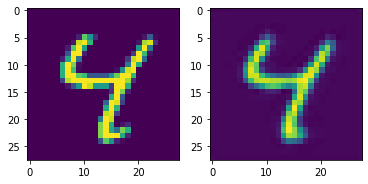

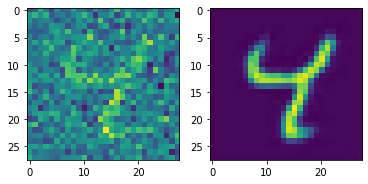

In [0]:
showEncodeDecode(dnauto_encode_decode_conv_big, test_data_xy[6][0])
showEncodeDecode(dnauto_encode_decode_conv_big, addNoise(test_data_xy[6][0]))

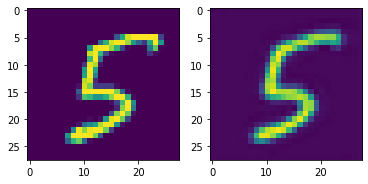

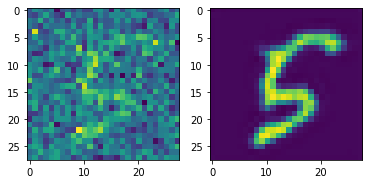

In [0]:
showEncodeDecode(dnauto_encode_decode_conv_big, test_data_xy[23][0])
showEncodeDecode(dnauto_encode_decode_conv_big, addNoise(test_data_xy[23][0]))

In [0]:
dnauto_encoder_conv_big2 = nn.Sequential(
    AdditiveGausNoise(),
    View(-1,1,28,28),
    nn.Conv2d(C, 2, (3,3), padding=1), # 1 * 28 *28 to 2 * 28 *28
    nn.BatchNorm2d(2),
    nn.ReLU(),
    AdditiveGausNoise(),
    nn.Conv2d(2, 2, (3,3), padding=1),# 2 * 28 *28 to 2 * 28 *28
    nn.BatchNorm2d(2),
    nn.ReLU(),
    AdditiveGausNoise(),
    nn.Conv2d(2, 2, (3,3), padding=1),# 2 * 28 *28 to 2 * 28 *28
    nn.BatchNorm2d(2),
    nn.ReLU(),
    AdditiveGausNoise(),
    nn.Conv2d(2, 2, (3,3), padding=1) # 2 * 28 *28 to 2 * 28 *28
)


dnauto_decoder_conv_big2 = nn.Sequential(
    nn.Conv2d(2, 2, (3,3), padding=1), # 2 * 28 *28 to 2 * 28 *28
    nn.BatchNorm2d(2),
    nn.ReLU(),
    nn.Conv2d(2, 2, (3,3), padding=1), # 2 * 28 *28 to 2 * 28 *28
    nn.BatchNorm2d(2),
    nn.ReLU(),
    nn.Conv2d(2, 2, (3,3), padding=1), # 2 * 28 *28 to 2 * 28 *28
    nn.BatchNorm2d(2),
    nn.ReLU(),
    nn.Conv2d(2, C, (3,3),padding=1)# 2 * 28 *28  to 1 * 28 * 28
)

dnauto_encode_decode_conv_big2 = nn.Sequential(
    dnauto_encoder_conv_big2,
    dnauto_decoder_conv_big2
)

In [0]:
train_network(dnauto_encode_decode_conv_big2, mse_loss, train_loader, val_loader=test_loader, epochs=10, device=device)

,epoch,total time,train loss,val loss
0,0,11.428350,3091.588429,3091.588429
1,1,23.119207,1119.178236,1119.178236
2,2,34.486203,993.515379,993.515379
3,3,45.965464,923.732518,923.732518
4,4,57.418148,881.175472,881.175472
5,5,68.889234,853.709717,853.709717
6,6,80.526973,834.589291,834.589291
7,7,91.859299,817.313576,817.313576
8,8,103.612610,807.371697,807.371697
9,9,115.178962,798.236076,798.236076


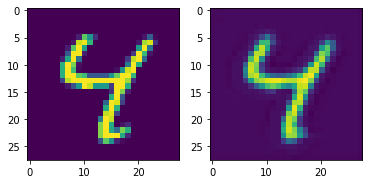

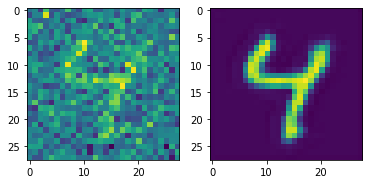

In [0]:
showEncodeDecode(dnauto_encode_decode_conv_big2, test_data_xy[6][0])
showEncodeDecode(dnauto_encode_decode_conv_big2, addNoise(test_data_xy[6][0]))

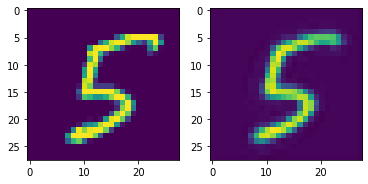

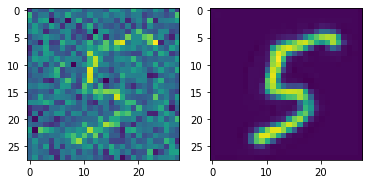

In [0]:
showEncodeDecode(dnauto_encode_decode_conv_big2, test_data_xy[23][0])
showEncodeDecode(dnauto_encode_decode_conv_big2, addNoise(test_data_xy[23][0]))

**Convolutional Denoising Auto Encoder with ConvTranspose2d**

**Conv2d**

$H_{out}$=$$\frac{H_{in} + 2×padding[0]
−dilation[0]×(kernel_size[0]−1)−1}{stride[0]} + 1$$
​	


$W_{out}$ = $$\frac{W_{in} + 2 × padding[1] - dilation[1] × (kernel_size[1] - 1) - 1}{stride[1]} + 1$$

**ConvTranspose2d**

$H_{out}$ = ($H_{in}$ - 1) × stride[0] - 2 ×padding[0] + dilation[0] × (kernel_size[0] - 1) + output_padding[0] + 1

$W_{out}$ = ($W_{in}$ - 1) × stride}[1] - 2 ×padding[1] + dilation[1] × (kernel\_size[1] - 1) + output_padding[1] + 1


[Formula Link](https://pytorch.org/docs/stable/nn.html)

In [0]:
dnauto_encoder_conv_convtranspose_big = nn.Sequential(
    AdditiveGausNoise(),
    View(-1,1,28,28),
    nn.Conv2d(C, 8, (3,3), stride=2,padding=1), # 1 * 28 *28 to 8 * 14 * 14
    nn.BatchNorm2d(8),
    nn.ReLU(),
    nn.Conv2d(8, 32, (3,3), stride=2, padding=1),# 8 * 14 * 14 to 32 * 7 * 7
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.Conv2d(32, 32, (3,3), stride=1, padding=1),# 32 * 7 * 7 to 32 * 7 * 7
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.Conv2d(32, 32, (3,3), stride=1, padding=1) # 32 * 7 * 7 to 32 * 7 * 7
)

dnauto_decoder_conv_convtranspose_big = nn.Sequential(
    nn.ConvTranspose2d(32, 32, (3,3), padding=1),# 32 * 7 * 7 to 32 * 7 * 7
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.ConvTranspose2d(32, 32, (3,3), padding=1),# 32 * 7 * 7 to 32 * 7 * 7
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.ConvTranspose2d(32, 8, (3,3), stride=2, padding=1, output_padding=1),# 32 * 7 * 7 to 8 * 14 * 14
    nn.BatchNorm2d(8),
    nn.ReLU(),
    nn.ConvTranspose2d(8, C, (3,3),stride=2,padding=1, output_padding=1)# 8 * 14 * 14 to 1 * 28 * 28
)

dnauto_encode_decode_conv_convtranspose_big = nn.Sequential(
    dnauto_encoder_conv_convtranspose_big,
    dnauto_decoder_conv_convtranspose_big
)

In [0]:
train_network(dnauto_encode_decode_conv_convtranspose_big, mse_loss, train_loader, val_loader=test_loader, epochs=10, device=device)

,epoch,total time,train loss,val loss
0,0,13.495891,2171.864129,2171.864129
1,1,26.788758,869.027090,869.027090
2,2,40.225836,770.357684,770.357684
3,3,53.588757,726.785429,726.785429
4,4,67.106867,700.077828,700.077828
5,5,80.559197,682.112997,682.112997
6,6,94.052061,671.168883,671.168883
7,7,107.450292,657.125203,657.125203
8,8,120.906129,650.304857,650.304857
9,9,134.440995,643.130252,643.130252


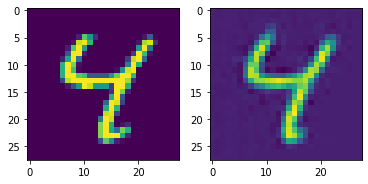

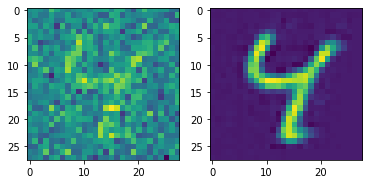

In [0]:
showEncodeDecode(dnauto_encode_decode_conv_convtranspose_big, test_data_xy[6][0])
showEncodeDecode(dnauto_encode_decode_conv_convtranspose_big, addNoise(test_data_xy[6][0]))

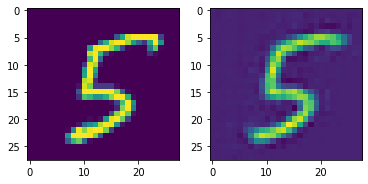

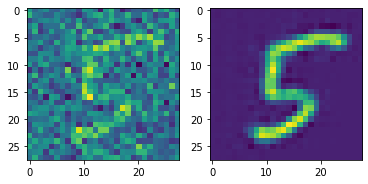

In [0]:
showEncodeDecode(dnauto_encode_decode_conv_convtranspose_big, test_data_xy[23][0])
showEncodeDecode(dnauto_encode_decode_conv_convtranspose_big, addNoise(test_data_xy[23][0]))

In [0]:
dnauto_encoder_conv_convtranspose_big2 = nn.Sequential(
    AdditiveGausNoise(),
    View(-1,1,28,28),
    nn.Conv2d(C, 8, (3,3), stride=2,padding=1), # 1 * 28 *28 to 8 * 14 * 14
    nn.BatchNorm2d(8),
    nn.ReLU(),
    AdditiveGausNoise(),
    nn.Conv2d(8, 32, (3,3), stride=2, padding=1),# 8 * 14 * 14 to 32 * 7 * 7
    nn.BatchNorm2d(32),
    nn.ReLU(),
    AdditiveGausNoise(),
    nn.Conv2d(32, 32, (3,3), stride=1, padding=1),# 32 * 7 * 7 to 32 * 7 * 7
    nn.BatchNorm2d(32),
    nn.ReLU(),
    AdditiveGausNoise(),
    nn.Conv2d(32, 32, (3,3), stride=1, padding=1) # 32 * 7 * 7 to 32 * 7 * 7
)

dnauto_decoder_conv_convtranspose_big2 = nn.Sequential(
    nn.ConvTranspose2d(32, 32, (3,3), padding=1),# 32 * 7 * 7 to 32 * 7 * 7
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.ConvTranspose2d(32, 32, (3,3), padding=1),# 32 * 7 * 7 to 32 * 7 * 7
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.ConvTranspose2d(32, 8, (3,3), stride=2, padding=1, output_padding=1),# 32 * 7 * 7 to 8 * 14 * 14
    nn.BatchNorm2d(8),
    nn.ReLU(),
    nn.ConvTranspose2d(8, C, (3,3),stride=2,padding=1, output_padding=1)# 8 * 14 * 14 to 1 * 28 * 28
)

dnauto_encode_decode_conv_convtranspose_big2 = nn.Sequential(
    dnauto_encoder_conv_convtranspose_big2,
    dnauto_decoder_conv_convtranspose_big2
)

In [0]:
train_network(dnauto_encode_decode_conv_convtranspose_big2, mse_loss, train_loader, val_loader=test_loader, epochs=10, device=device)

,epoch,total time,train loss,val loss
0,0,16.695499,1882.546380,1882.546380
1,1,33.437539,986.958656,986.958656
2,2,50.213467,876.625171,876.625171
3,3,66.995042,820.633916,820.633916
4,4,83.819465,784.017819,784.017819
5,5,100.590675,757.256411,757.256411
6,6,117.301809,735.773841,735.773841
7,7,134.232144,718.556290,718.556290
8,8,150.897872,704.954353,704.954353
9,9,167.714564,693.438727,693.438727


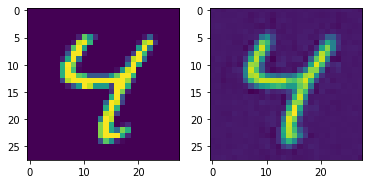

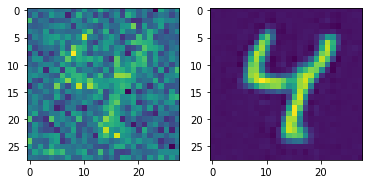

In [0]:
showEncodeDecode(dnauto_encode_decode_conv_convtranspose_big2, test_data_xy[6][0])
showEncodeDecode(dnauto_encode_decode_conv_convtranspose_big2, addNoise(test_data_xy[6][0]))

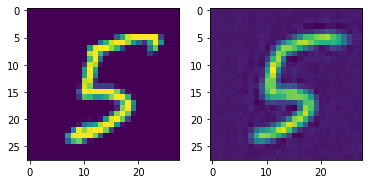

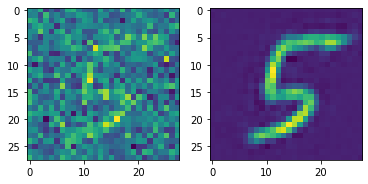

In [0]:
showEncodeDecode(dnauto_encode_decode_conv_convtranspose_big2, test_data_xy[23][0])
showEncodeDecode(dnauto_encode_decode_conv_convtranspose_big2, addNoise(test_data_xy[23][0]))

**Convolutional Denoising Auto Encoder with Maxpool2d and ConvTranspose2d**

**MaxPool2d**

$H_{out}$=$$\frac{H_{in} + 2×padding[0]
−dilation[0]×(kernel_size[0]−1)−1}{stride[0]} + 1$$
​	


$W_{out}$ = $$\frac{W_{in} + 2 × padding[1] - dilation[1] × (kernel_size[1] - 1) - 1}{stride[1]} + 1$$

In [0]:
dnauto_encoder_conv_max_big = nn.Sequential(
    AdditiveGausNoise(),
    View(-1,1,28,28),
    nn.Conv2d(C, 2, (3,3), padding=1), # 1 * 28 *28 to 2 * 28 *28
    nn.BatchNorm2d(2),
    nn.ReLU(),
    nn.Conv2d(2, 2, (3,3), padding=1),# 2 * 28 *28 to 2 * 28 *28
    nn.BatchNorm2d(2),
    nn.ReLU(),
    nn.Conv2d(2, 8, (3,3), padding=1),# 2 * 28 *28 to 8 * 28 *28
    nn.BatchNorm2d(8),
    nn.ReLU(),
    nn.MaxPool2d((2,2))# 8 * 28 *28 to 8 * 14 *14 #2 stride 2 kernel size make the C*W*H//4 or (C,W//2,H//2) shaped
    
)

dnauto_decoder_conv_max_big = nn.Sequential(
    nn.ConvTranspose2d(8, 8, (2,2), stride=2), # 8 * 14 *14 to 8 * 28 *28
    nn.BatchNorm2d(8),
    nn.ReLU(),
    nn.Conv2d(8, 2, (3,3), padding=1), # 8 * 28 *28 to 2 * 28 *28
    nn.BatchNorm2d(2),
    nn.ReLU(),
    nn.Conv2d(2, 2, (3,3), padding=1), # 2 * 28 *28 to 2 * 28 *28
    nn.BatchNorm2d(2),
    nn.ReLU(),
    nn.Conv2d(2, C, (3,3),padding=1)# 2 * 28 *28  to 1 * 28 * 28
)

dnauto_encode_decode_conv_max_big = nn.Sequential(
    dnauto_encoder_conv_max_big,
    dnauto_decoder_conv_max_big
)

In [0]:
train_network(dnauto_encode_decode_conv_max_big, mse_loss, train_loader, val_loader=test_loader, epochs=10, device=device)

,epoch,total time,train loss,val loss
0,0,8.236961,2286.913517,2286.913517
1,1,16.275362,963.836598,963.836598
2,2,24.324652,860.899627,860.899627
3,3,32.490852,817.817217,817.817217
4,4,40.669602,794.363349,794.363349
5,5,48.723525,777.632773,777.632773
6,6,56.991614,766.149960,766.149960
7,7,65.403269,755.452903,755.452903
8,8,73.710793,746.232882,746.232882
9,9,81.933544,741.706279,741.706279


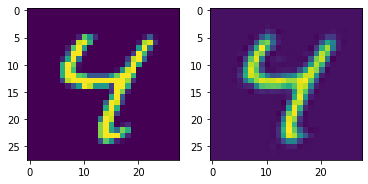

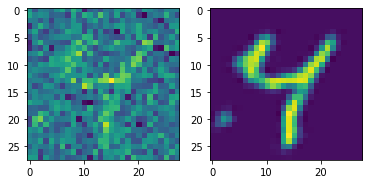

In [0]:
showEncodeDecode(dnauto_encode_decode_conv_max_big, test_data_xy[6][0])
showEncodeDecode(dnauto_encode_decode_conv_max_big, addNoise(test_data_xy[6][0]))

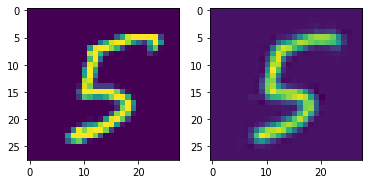

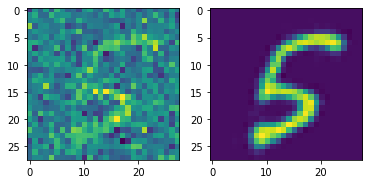

In [0]:
showEncodeDecode(dnauto_encode_decode_conv_max_big, test_data_xy[23][0])
showEncodeDecode(dnauto_encode_decode_conv_max_big, addNoise(test_data_xy[23][0]))

In [0]:
dnauto_encoder_conv_max_big2 = nn.Sequential(
    AdditiveGausNoise(),
    View(-1,1,28,28),
    nn.Conv2d(C, 2, (3,3), padding=1), # 1 * 28 *28 to 2 * 28 *28
    nn.BatchNorm2d(2),
    nn.ReLU(),
    AdditiveGausNoise(),
    nn.Conv2d(2, 2, (3,3), padding=1),# 2 * 28 *28 to 2 * 28 *28
    nn.BatchNorm2d(2),
    nn.ReLU(),
    AdditiveGausNoise(),
    nn.Conv2d(2, 8, (3,3), padding=1),# 2 * 28 *28 to 8 * 28 *28
    nn.BatchNorm2d(8),
    nn.ReLU(),
    AdditiveGausNoise(),
    nn.MaxPool2d((2,2))# 8 * 28 *28 to 8 * 14 *14 #2 stride 2 kernel size make the C*W*H//4 or (C,W//2,H//2) shaped
    
)

dnauto_decoder_conv_max_big2 = nn.Sequential(
    nn.ConvTranspose2d(8, 8, (2,2), stride=2), # 8 * 14 *14 to 8 * 28 *28
    nn.BatchNorm2d(8),
    nn.ReLU(),
    nn.Conv2d(8, 2, (3,3), padding=1), # 8 * 28 *28 to 2 * 28 *28
    nn.BatchNorm2d(2),
    nn.ReLU(),
    nn.Conv2d(2, 2, (3,3), padding=1), # 2 * 28 *28 to 2 * 28 *28
    nn.BatchNorm2d(2),
    nn.ReLU(),
    nn.Conv2d(2, C, (3,3),padding=1)# 2 * 28 *28  to 1 * 28 * 28
)

dnauto_encode_decode_conv_max_big2 = nn.Sequential(
    dnauto_encoder_conv_max_big2,
    dnauto_decoder_conv_max_big2
)

In [0]:
train_network(dnauto_encode_decode_conv_max_big2, mse_loss, train_loader, val_loader=test_loader, epochs=10, device=device)

,epoch,total time,train loss,val loss
0,0,14.660124,848.144233,848.144233
1,1,29.187089,835.510857,835.510857
2,2,43.869257,825.044803,825.044803
3,3,58.410566,817.356816,817.356816
4,4,73.075689,809.233976,809.233976
5,5,87.532853,804.677285,804.677285
6,6,102.167666,799.887407,799.887407
7,7,116.629644,795.173471,795.173471
8,8,131.277437,793.407632,793.407632
9,9,145.773162,787.723706,787.723706


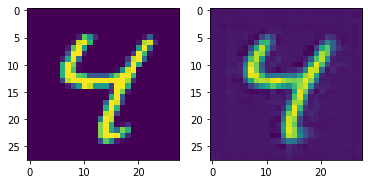

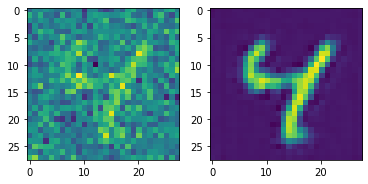

In [0]:
showEncodeDecode(dnauto_encode_decode_conv_max_big2, test_data_xy[6][0])
showEncodeDecode(dnauto_encode_decode_conv_max_big2, addNoise(test_data_xy[6][0]))

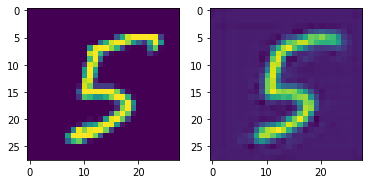

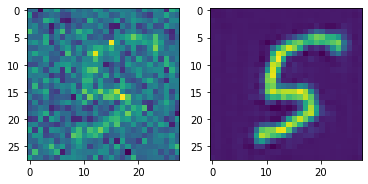

In [0]:
showEncodeDecode(dnauto_encode_decode_conv_max_big2, test_data_xy[23][0])
showEncodeDecode(dnauto_encode_decode_conv_max_big2, addNoise(test_data_xy[23][0]))

**2) Compare the Denoising CNN and the large Denoising Auto Encoder from the lecture numerically and qualitatively. Which one is better? Why?**

**Comparing the Denoising CNN and the large Denoising Auto Encoder from the lecture** 
* Denoising CNN Auto Encoder is better than the large Denoising Auto Encoder from the lecture.

**Numerically Comparison** 
* Denoising CNN Auto Encoder's taring loss and validation loss(listed below) is much less than the large Denoising Auto Encoder's taring loss and validation loss(873.606800) and taring loss and validation loss(913.972139) of large Denoising Auto Encoder with noise added to the input of several layers .

* Taring loss and Validation loss For :
   * Denoising CNN Auto Encoder's : 748.090348
   * Denoising CNN Auto Encoder's with noise added to the input of several layers : 798.236076
   * Denoising CNN Auto Encoder's with ConvTranspose2d : 643.130252
   * Denoising CNN Auto Encoder's with ConvTranspose2d and noise added to the input of several layers : 693.438727
   * Denoising CNN Auto Encoder's with MaxPool2D and ConvTranspose2d : 741.706279
   * Denoising CNN Auto Encoder's with MaxPool2D and ConvTranspose2d and noise added to the input of several layers : 787.723706

**Qualitatively Comparison**
* The denoising CNN Auto Encoder models are clearly the best at creating reconstructions than the large Denoising Auto Encoder from the lecture.
* The reconstructed image by denoising CNN Auto Encoders able to identify the noise and discard the noise while reconstructing and able to create good reconstruction without any hazyness around the object(digit) in the image except Denoising CNN Auto Encoder's with ConvTranspose2d and Denoising CNN Auto Encoder's with MaxPool2D and ConvTranspose2d and noise added to the input of several layers.
* From the reconstructed image it is evident that denoising CNN Auto Encoders are the more accurate and robust models.
* I have tried different layerd Denoising CNN Auto Encoders and most of networks have able to capture even minute details from the original input. 
  * For 4 has a lot of unique curve and style to it that are also faithfully preserved by   
    * Denoising CNN Auto Encoder 
    * Denoising CNN Auto Encoder's with ConvTranspose2d
    * Denoising CNN Auto Encoder's with MaxPool2D and ConvTranspose2d 
    * Denoising CNN Auto Encoder's with MaxPool2D and ConvTranspose2d and noise added to the input of several layers.
  * For 5 the models reconstructed as per the input. Preserve the unique structure by 
    * Denoising CNN Auto Encoder's with noise added to the input of several layers.
   * Denoising CNN Auto Encoder's with ConvTranspose2d.
   * Denoising CNN Auto Encoder's with ConvTranspose2d and noise added to the input of several layers 
   * Denoising CNN Auto Encoder's with MaxPool2D and ConvTranspose2d and noise added to the input of several layers
* Goal is not to just learn to reconstruct inputs from themsleves. Goal is to learn a useful representation of the data, without needing to know the labels of the data. Following models have on its own learned image of generic 5. 
    * Denoising CNN Auto Encoder
    * Denoising CNN Auto Encoder's with MaxPool2D and ConvTranspose2d.

It shows that without being explicitly told about the concept of 5, or that there are even distinct numbers present.


**Reasons**
* The Denoising CNN Auto encoders take advantage of some spatial correlation.The Denoising CNN Auto encoders keep the spatial information of the input image data as they are, and extract information gently in what is called the Convolution layer.This process is able to retain the spatial relationships in the data this spatial corelation learned by the model and create better reconstruction utilizing the spatiality.
* The Conv layer perform denoising well and extract features that capture useful structure in the distribution of the input.More filters mean more number of features that the model can extract.This feature learn helps to generate the better reconstruction of image.
* The convolutional layers capture the abstraction of image contents while eliminating noise. 
* Pooling is used here to perform down-sampling operations to reduce the dimensionality and creates a pooled feature map and precise feature to leran and then used convTranspose2d to exapnd back from the shinked shaped.
* Convtranspose layers have the capability to upsample the feature maps and recover the image details.
* As in Denoising CNN Auto encoders we can tune the model using this functionality of CNN(like, filters for feature extraction,pooled feature map to learn precise feature using pooling layer and then upsample the feature maps and recover
the image details and leran from spatial correlation) enable to provide relatively less losses and better reconstruction of image.



**3) Tell me your initial project idea & if you are going to have a partner who the partner is. (limit is teams of 2)**

* For my project, I am planning to implement Unpaired Image-to-Image Translation using CycleGAN (Cycle-Consistent Generative Adversarial Networks). The implementation will be based on the [CycleGAN Paper](https://arxiv.org/pdf/1703.10593.pdf).
* CycleGAN is a process for training unsupervised image translation models via the Generative Adverserial Network (GAN) architecture using unpaired collections of images from two different domains.
* CycleGAN has previously been demonstrated on a range of applications. I am planning to perform object transfiguration, for example transforming images of horse to zebra and the reverse, images of zebra to horse.
* For Dataset I will use the [horse2zebra dataset]('https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/horse2zebra.zip').
* I plan to do a solo project.

# Grade: 110/100

Wow, above an beyond on this homework, very good job! Enjoy the extra-credit bonus for doing so much extra! 

My one comment would be that your use of only 2 filters in many of your CNNs is exceptionally small. While it does work on MNIST, due to MNIST's simplicity, it is generally not useful to try unless you have a very specifc hypothesis you are testing. I might do that if Ithought there was a bug in my code, or a data quality problem, and I wanted to see if it can get better results than it should. In general, I would use a minimum of 32 filters for most real world problems. 

Hopefully the recent lecture clarified when / where to use a Tranposed convolution. This was unecessary for your architecture's design, but it dosn't hurt to try new things :) 

We have talked about your project before, and its still good by me! Remember that a good project dosn't necessarily have to be working/complete. I'm looking for the kind of stuff you have in this HW, detailed results showing what you did/tried, progress, and what you understood / learned. 